# Sequential Training Pipeline

Train models sequentially across multiple days:
- **Dataset**: TOTF
- **Scaler**: Box-Cox
- **Models**: Transformer+OCSVM, PRAE, PNN
- **Training Strategy**: Train on first hour of each day (5-min blocks), test on rest of day
- **Final Test**: Final Day (25) (morning + rest of day)

In [1]:
import os
import torch
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from PDMM import preprocessing as prep
from PDMM import  machine_learning as ml
from PDMM import visualization as viz
from PDMM.pipeline import AnomalyDetectionPipeline, sequential_training_pipeline

os.makedirs('../models', exist_ok=True)

## Configuration

In [10]:
# Data Configuration
DATA_DIR = '../data/TOTF.PA-book'  # Directory with daily TOTF files
SCALER_TYPE = 'box-cox'

# Sequential Training Parameters
NUM_DAYS = 7  # Train on first 24 days
FIRST_HOUR_MINUTES = 60  # Use first hour of each day
TRAIN_BLOCK_MINUTES = 5  # 5-minute training blocks
VAL_BLOCK_MINUTES = 5    # 5-minute validation blocks

# Model Hyperparameters
SEQ_LENGTH = 25
BATCH_SIZE = 128
EPOCHS = 1
HIDDEN_DIM = 64
LR = 1e-3
PATIENCE = 2

# Model Types to Train
MODELS = ['transformer_ocsvm', 'prae', 'pnn']

# Feature Sets
FEATURE_SETS = ['base', 'tao', 'poutre', 'hawkes', 'ofi']

## Check Available Data Files

In [3]:
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(('.csv', '.csv.gz', '.parquet'))])
print(f"Found {len(files)} data files in {DATA_DIR}")

Found 25 data files in ../data/TOTF.PA-book


## Train Models Sequentially

Train each model type on 30 days, evaluate on rest of each day + Day 31

### 1. Transformer + OC-SVM

In [4]:
print("TRAINING: Transformer + OC-SVM")

results_transformer, pipeline_transformer = sequential_training_pipeline(
    data_dir=DATA_DIR,
    num_days=NUM_DAYS,
    first_hour_minutes=FIRST_HOUR_MINUTES,
    train_block_minutes=TRAIN_BLOCK_MINUTES,
    val_block_minutes=VAL_BLOCK_MINUTES,
    model_type='transformer_ocsvm',
    feature_sets=FEATURE_SETS,
    epochs=EPOCHS,
    lr=LR,
    nu=0.01,
    hidden_dim=HIDDEN_DIM,
    patience=PATIENCE,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

# Save results
with open('../models/TOTF_sequential_transformer_ocsvm_results.json', 'w') as f:
    json.dump(results_transformer, f, indent=2)

# Save trained model
base_filename = f"../models/TOTF_{SCALER_TYPE}_transformer_ocsvm_sequential"
torch.save(pipeline_transformer.model.state_dict(), f"{base_filename}_weights.pth")
joblib.dump(pipeline_transformer.scaler, f"{base_filename}_scaler.pkl")
if pipeline_transformer.detector is not None:
    joblib.dump(pipeline_transformer.detector, f"{base_filename}_ocsvm_detector.pkl")
    joblib.dump(pipeline_transformer.latent_scaler, f"{base_filename}_latent_scaler.pkl")

config = {
    'dataset': 'TOTF',
    'model_type': 'transformer_ocsvm',
    'scaler_type': SCALER_TYPE,
    'training_type': 'sequential',
    'num_days': NUM_DAYS,
    'seq_length': SEQ_LENGTH,
    'input_dim': len(pipeline_transformer.feature_names),
    'hidden_dim': HIDDEN_DIM,
    'batch_size': BATCH_SIZE,
    'feature_names': pipeline_transformer.feature_names
}
with open(f"{base_filename}_config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nSaved Transformer+OCSVM model to {base_filename}")

TRAINING: Transformer + OC-SVM
Pipeline initialized on device: cuda
Starting sequential training on 7 days...
Train block: 5 min, Val block: 5 min
Day 1/7: 2015-01-02-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Filtered 2801 pre-market samples.
First hour samples: 74476, Rest of day: 563152
Training on 6 time blocks...
Block 1/6: Train=13129, Val=8126
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\pipeline.py:140: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.clip(lower=lower, upper=upper, axis=1)


Feature Engineering complete. Total features: 130
Initializing transformer_ocsvm model...
Initializing Transformer Autoencoder...
Training Autoencoder (Max Epochs=1000)...
Epoch 1/1000 - Train Loss: 0.720372 | Val Loss: 1.198995
Validation loss decreased (inf --> 1.198995).  Saving model ...
Epoch 2/1000 - Train Loss: 0.531796 | Val Loss: 1.138108
Validation loss decreased (1.198995 --> 1.138108).  Saving model ...
Epoch 3/1000 - Train Loss: 0.473408 | Val Loss: 1.088693
Validation loss decreased (1.138108 --> 1.088693).  Saving model ...
Epoch 4/1000 - Train Loss: 0.432147 | Val Loss: 1.074286
Validation loss decreased (1.088693 --> 1.074286).  Saving model ...
Epoch 5/1000 - Train Loss: 0.411131 | Val Loss: 1.046664
Validation loss decreased (1.074286 --> 1.046664).  Saving model ...
Epoch 6/1000 - Train Loss: 0.377402 | Val Loss: 1.034993
Validation loss decreased (1.046664 --> 1.034993).  Saving model ...
Epoch 7/1000 - Train Loss: 0.356366 | Val Loss: 1.017319
Validation loss decr

c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\pipeline.py:140: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.clip(lower=lower, upper=upper, axis=1)


Feature Engineering complete. Total features: 130
Incremental training...
Initializing Transformer Autoencoder...
Training Autoencoder (Max Epochs=500)...
Epoch 1/500 - Train Loss: 289910.352823 | Val Loss: 290044.260913
Validation loss decreased (inf --> 290044.260913).  Saving model ...
Epoch 2/500 - Train Loss: 289647.440020 | Val Loss: 289769.917163
Validation loss decreased (290044.260913 --> 289769.917163).  Saving model ...
Epoch 3/500 - Train Loss: 289341.171875 | Val Loss: 289442.613095
Validation loss decreased (289769.917163 --> 289442.613095).  Saving model ...
Epoch 4/500 - Train Loss: 288986.075605 | Val Loss: 289066.876488
Validation loss decreased (289442.613095 --> 289066.876488).  Saving model ...
Epoch 5/500 - Train Loss: 288587.240423 | Val Loss: 288644.268849
Validation loss decreased (289066.876488 --> 288644.268849).  Saving model ...
Epoch 6/500 - Train Loss: 288141.698589 | Val Loss: 288174.688492
Validation loss decreased (288644.268849 --> 288174.688492).  Sa

### 2. Probabilistic Robust Autoencoder (PRAE)

In [11]:
print("TRAINING: PRAE")

results_prae, pipeline_prae = sequential_training_pipeline(
    data_dir=DATA_DIR,
    num_days=NUM_DAYS,
    first_hour_minutes=FIRST_HOUR_MINUTES,
    train_block_minutes=TRAIN_BLOCK_MINUTES,
    val_block_minutes=VAL_BLOCK_MINUTES,
    model_type='prae',
    feature_sets=FEATURE_SETS,
    epochs=EPOCHS,
    lr=LR,
    lambda_reg=0.1,
    hidden_dim=HIDDEN_DIM,
    patience=PATIENCE,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

# Save results
with open('../models/TOTF_sequential_prae_results.json', 'w') as f:
    json.dump(results_prae, f, indent=2)

# Save trained model
base_filename = f"../models/TOTF_{SCALER_TYPE}_prae_sequential"
torch.save(pipeline_prae.model.state_dict(), f"{base_filename}_weights.pth")
joblib.dump(pipeline_prae.scaler, f"{base_filename}_scaler.pkl")

config = {
    'dataset': 'TOTF',
    'model_type': 'prae',
    'scaler_type': SCALER_TYPE,
    'training_type': 'sequential',
    'num_days': NUM_DAYS,
    'seq_length': SEQ_LENGTH,
    'input_dim': len(pipeline_prae.feature_names),
    'hidden_dim': HIDDEN_DIM,
    'batch_size': BATCH_SIZE,
    'feature_names': pipeline_prae.feature_names
}
with open(f"{base_filename}_config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nSaved PRAE model to {base_filename}")

TRAINING: PRAE
Pipeline initialized on device: cuda
Starting sequential training on 7 days...
Train block: 5 min, Val block: 5 min
Day 1/7: 2015-01-02-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Filtered 2801 pre-market samples.
First hour samples: 74476, Rest of day: 563152
Training on 6 time blocks...
Block 1/6: Train=13129, Val=8126
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\pipeline.py:140: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.clip(lower=lower, upper=upper, axis=1)


Feature Engineering complete. Total features: 130
Initializing prae model...
Initializing Probabilistic Robust Autoencoder (PRAE)...
Training PRAE (lambda=0.100000, Max Epochs=1)...
Epoch 1/1 - Train Loss: 0.494334 | Val MSE: 1.226887
Validation loss decreased (inf --> 1.226887).  Saving model ...
Block 2/6: Train=7048, Val=5332
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Incremental training...
Initializing Probabilistic Robust Autoencoder (PRAE)...
Training PRAE (lambda=0.100000, Max Epochs=2)...
Epoch 1/2 - Train Loss: 0.543579 | Val MSE: 1.430083
Validation loss decreased (inf --> 1.430083).  Saving model ...
Epoch 2/2 - Train Loss: 0.402409 | Val MSE: 1.339703
Validation loss decreased (1.430083 --> 1.339703).  Saving model ...
Block 3/6: Train=7584, Val=5681
Engineering features: ['base', 't

c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\pipeline.py:140: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.clip(lower=lower, upper=upper, axis=1)


Feature Engineering complete. Total features: 130
Incremental training...
Initializing Probabilistic Robust Autoencoder (PRAE)...
Training PRAE (lambda=0.100000, Max Epochs=2)...
Epoch 1/2 - Train Loss: 217640.020917 | Val MSE: 290039.436012
Validation loss decreased (inf --> 290039.436012).  Saving model ...
Epoch 2/2 - Train Loss: 217907.927167 | Val MSE: 289767.494048
Validation loss decreased (290039.436012 --> 289767.494048).  Saving model ...

Evaluating on rest of Day 6...
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Evaluating model...
Day 6 Results: AUROC=1.0000, AUPRC=1.0000, F4=1.0000
Day 7/7: 2015-01-12-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-12-TOTF.PA-book.csv.gz...
Successfully loaded 1178388 rows.
Filtered 2074 pre-market samples.
First hour samples: 97467, Rest of day: 1078847
Training on 6 

### 3. Probabilistic Neural Network (PNN)

In [12]:
print("TRAINING: PNN")

results_pnn, pipeline_pnn = sequential_training_pipeline(
    data_dir=DATA_DIR,
    num_days=NUM_DAYS,
    first_hour_minutes=FIRST_HOUR_MINUTES,
    train_block_minutes=TRAIN_BLOCK_MINUTES,
    val_block_minutes=VAL_BLOCK_MINUTES,
    model_type='pnn',
    feature_sets=FEATURE_SETS,
    epochs=EPOCHS,
    lr=LR,
    hidden_dim=HIDDEN_DIM,
    patience=PATIENCE,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

# Save results
with open('../models/TOTF_sequential_pnn_results.json', 'w') as f:
    json.dump(results_pnn, f, indent=2)

# Save trained model
base_filename = f"../models/TOTF_{SCALER_TYPE}_pnn_sequential"
torch.save(pipeline_pnn.model.state_dict(), f"{base_filename}_weights.pth")
joblib.dump(pipeline_pnn.scaler, f"{base_filename}_scaler.pkl")

config = {
    'dataset': 'TOTF',
    'model_type': 'pnn',
    'scaler_type': SCALER_TYPE,
    'training_type': 'sequential',
    'num_days': NUM_DAYS,
    'seq_length': SEQ_LENGTH,
    'input_dim': len(pipeline_pnn.feature_names),
    'hidden_dim': HIDDEN_DIM,
    'batch_size': BATCH_SIZE,
    'feature_names': pipeline_pnn.feature_names
}
with open(f"{base_filename}_config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nSaved PNN model to {base_filename}")

TRAINING: PNN
Pipeline initialized on device: cuda
Starting sequential training on 7 days...
Train block: 5 min, Val block: 5 min
Day 1/7: 2015-01-02-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Filtered 2801 pre-market samples.
First hour samples: 74476, Rest of day: 563152
Training on 6 time blocks...
Block 1/6: Train=13129, Val=8126
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\pipeline.py:140: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.clip(lower=lower, upper=upper, axis=1)


Feature Engineering complete. Total features: 130
Initializing pnn model...
Initializing Probabilistic Neural Network (PNN)...
Training PNN (Max Epochs=1)...
Epoch 1/1 - Train: 1.210866 | Val: 2.948100
Validation loss decreased (inf --> 2.948100).  Saving model ...
Block 2/6: Train=7048, Val=5332
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Incremental training...
Initializing Probabilistic Neural Network (PNN)...
Training PNN (Max Epochs=2)...
Epoch 1/2 - Train: 0.914392 | Val: 1.023253
Validation loss decreased (inf --> 1.023253).  Saving model ...
Epoch 2/2 - Train: 0.645788 | Val: 1.310558
EarlyStopping counter: 1 out of 2
Block 3/6: Train=7584, Val=5681
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Engineering features: ['

c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\pipeline.py:140: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.clip(lower=lower, upper=upper, axis=1)


Feature Engineering complete. Total features: 130
Incremental training...
Initializing Probabilistic Neural Network (PNN)...
Training PNN (Max Epochs=2)...
Epoch 1/2 - Train: 23.025850 | Val: 23.025850
Validation loss decreased (inf --> 23.025850).  Saving model ...
Epoch 2/2 - Train: 23.025850 | Val: 23.025850
Validation loss decreased (23.025850 --> 23.025850).  Saving model ...

Evaluating on rest of Day 6...
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 130
Evaluating model...
Day 6 Results: AUROC=0.5000, AUPRC=0.5000, F4=0.0000
Day 7/7: 2015-01-12-TOTF.PA-book.csv.gz
--------------------------------------------------------------------------------
Loading data from ../data/TOTF.PA-book\2015-01-12-TOTF.PA-book.csv.gz...
Successfully loaded 1178388 rows.
Filtered 2074 pre-market samples.
First hour samples: 97467, Rest of day: 1078847
Training on 6 time blocks...
Block 1/6: Train=7468, Val=5928
Engineering features: 

## Visualize Results

### Transformer + OC-SVM Results

Sequential training results plot saved to ../results/training/figures/TOTF_sequential_transformer_ocsvm_results.png


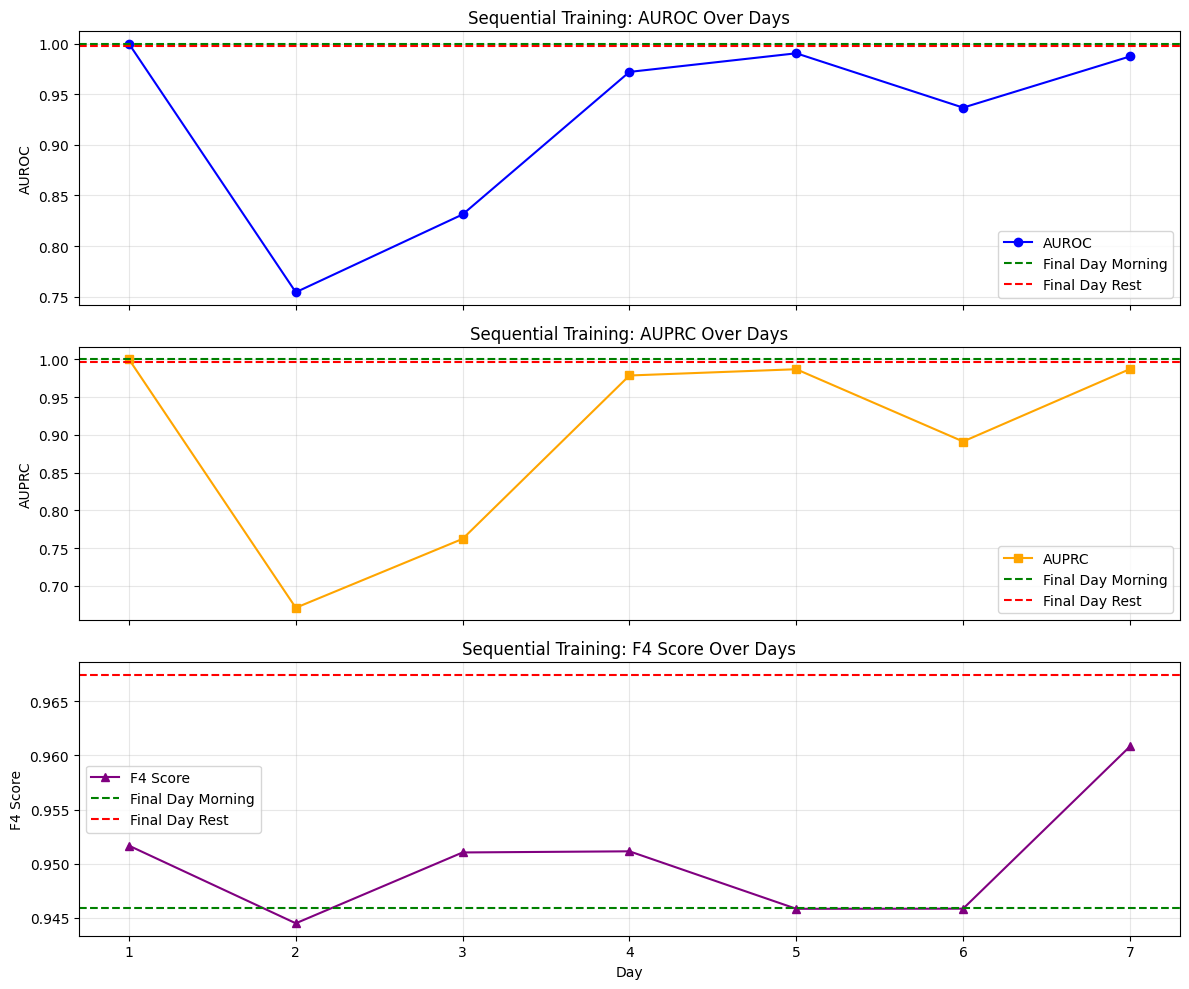

In [6]:
viz.plot_sequential_results(results_transformer, save_path='../results/training/figures/TOTF_sequential_transformer_ocsvm_results.png')

### PRAE Results

Sequential training results plot saved to ../results/training/figures/TOTF_sequential_prae_results.png


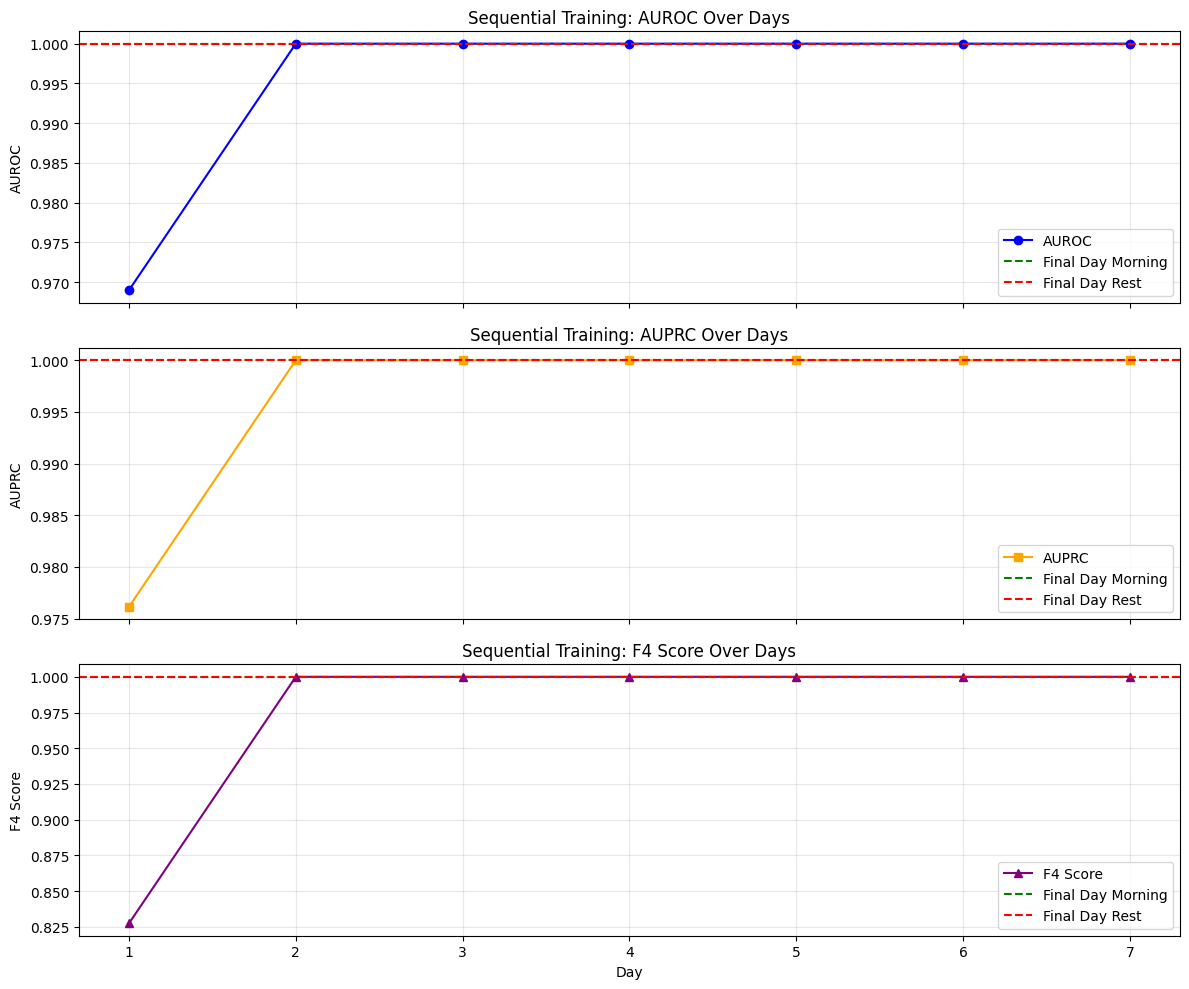

In [13]:
viz.plot_sequential_results(results_prae, save_path='../results/training/figures/TOTF_sequential_prae_results.png')

### PNN Results

Sequential training results plot saved to ../results/training/figures/TOTF_sequential_pnn_results.png


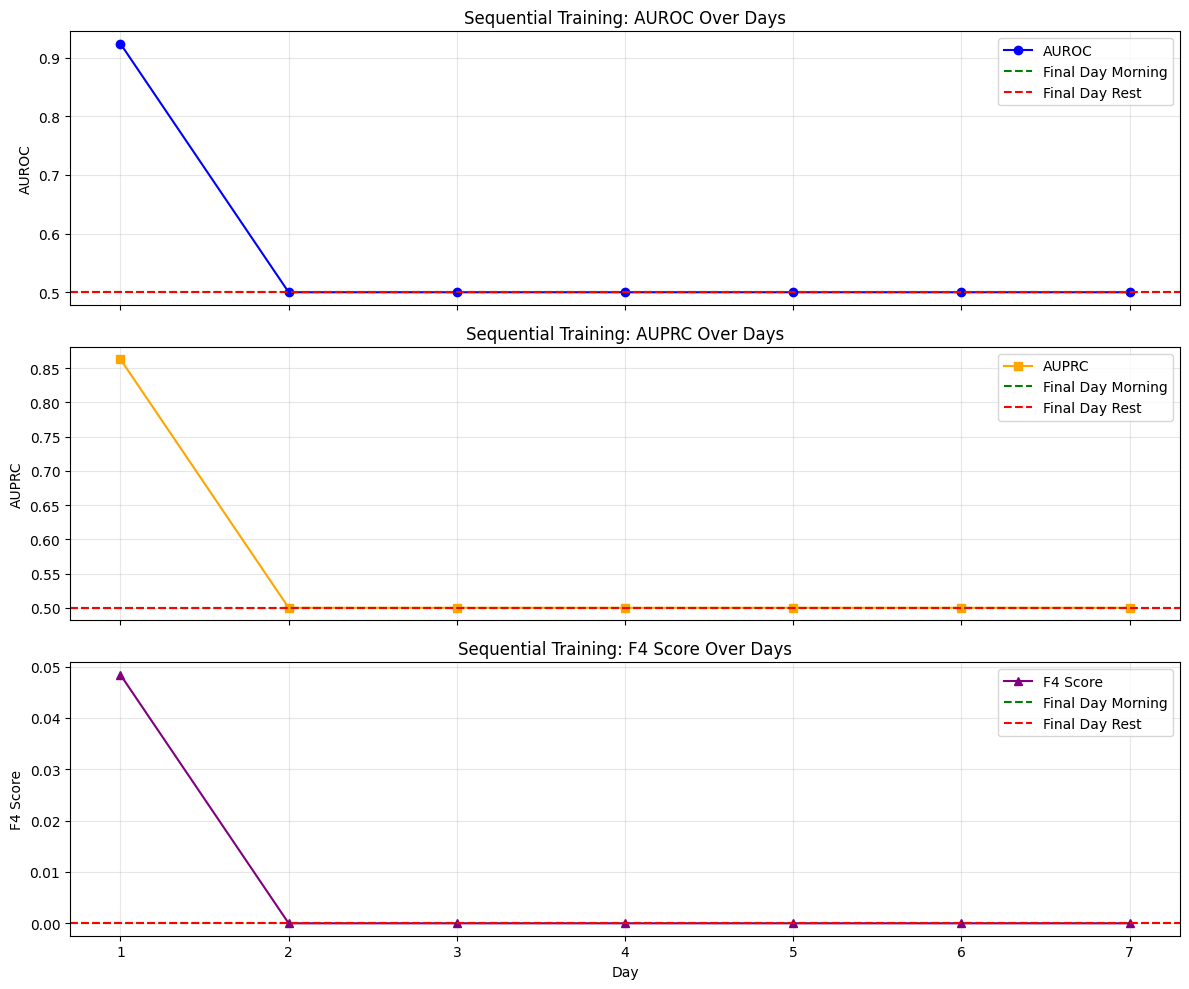

In [14]:
viz.plot_sequential_results(results_pnn, save_path='../results/training/figures/TOTF_sequential_pnn_results.png')

## Compare All Models

In [15]:
# Create comparison DataFrame
comparison_data = []

for model_name, results in [('Transformer+OCSVM', results_transformer), 
                             ('PRAE', results_prae), 
                             ('PNN', results_pnn)]:
    
    # Average over all training days
    daily_df = pd.DataFrame(results['daily_metrics'])
    avg_metrics = {
        'Model': model_name,
        'Avg_AUROC': daily_df['AUROC'].mean(),
        'Avg_AUPRC': daily_df['AUPRC'].mean(),
        'Avg_F4': daily_df['F4_Score'].mean(),
    }
    
    # Final Day Morning
    if results['final_day_morning_metrics']:
        avg_metrics['FinalDay_Morning_AUROC'] = results['final_day_morning_metrics']['AUROC']
        avg_metrics['FinalDay_Morning_AUPRC'] = results['final_day_morning_metrics']['AUPRC']
        avg_metrics['FinalDay_Morning_F4'] = results['final_day_morning_metrics']['F4_Score']
    
    # Final Day Rest
    if results['final_day_rest_metrics']:
        avg_metrics['FinalDay_Rest_AUROC'] = results['final_day_rest_metrics']['AUROC']
        avg_metrics['FinalDay_Rest_AUPRC'] = results['final_day_rest_metrics']['AUPRC']
        avg_metrics['FinalDay_Rest_F4'] = results['final_day_rest_metrics']['F4_Score']
    
    comparison_data.append(avg_metrics)

comparison_df = pd.DataFrame(comparison_data)
print("MODEL COMPARISON - Sequential Training")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('../results/training/TOTF_sequential_model_comparison.csv', index=False)
print("\nSaved comparison to ../results/training/TOTF_sequential_model_comparison.csv")

MODEL COMPARISON - Sequential Training
            Model  Avg_AUROC  Avg_AUPRC   Avg_F4  FinalDay_Morning_AUROC  FinalDay_Morning_AUPRC  FinalDay_Morning_F4  FinalDay_Rest_AUROC  FinalDay_Rest_AUPRC  FinalDay_Rest_F4
Transformer+OCSVM   0.924656   0.896688 0.950126                0.999877                0.999875             0.945909             0.998062             0.996329          0.967444
             PRAE   0.995568   0.996591 0.975337                1.000000                1.000000             1.000000             1.000000             1.000000          1.000000
              PNN   0.560519   0.551830 0.006914                0.500000                0.500000             0.000000             0.500000             0.500000          0.000000

Saved comparison to ../results/training/TOTF_sequential_model_comparison.csv


## Summary Statistics

In [16]:
print("SEQUENTIAL TRAINING SUMMARY")
print(f"Dataset: TOTF")
print(f"Scaler: {SCALER_TYPE}")
print(f"Training Days: {NUM_DAYS}")
print(f"Training Strategy: First {FIRST_HOUR_MINUTES} minutes per day")
print(f"  - Train blocks: {TRAIN_BLOCK_MINUTES} minutes")
print(f"  - Val blocks: {VAL_BLOCK_MINUTES} minutes")
print(f"Test: Rest of each day + Final Day (morning & rest)")
print("\nHyperparameters:")
print(f"  - Sequence Length: {SEQ_LENGTH}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs per block: {EPOCHS}")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Learning Rate: {LR}")
print("\nBest Model (by Final Day Rest AUROC):")
best_idx = comparison_df['FinalDay_Rest_AUROC'].idxmax()
best_model = comparison_df.loc[best_idx]
print(f"  {best_model['Model']}")
print(f"  - AUROC: {best_model['FinalDay_Rest_AUROC']:.4f}")
print(f"  - AUPRC: {best_model['FinalDay_Rest_AUPRC']:.4f}")
print(f"  - F4 Score: {best_model['FinalDay_Rest_F4']:.4f}")

SEQUENTIAL TRAINING SUMMARY
Dataset: TOTF
Scaler: box-cox
Training Days: 7
Training Strategy: First 60 minutes per day
  - Train blocks: 5 minutes
  - Val blocks: 5 minutes
Test: Rest of each day + Final Day (morning & rest)

Hyperparameters:
  - Sequence Length: 25
  - Batch Size: 128
  - Epochs per block: 1
  - Hidden Dim: 64
  - Learning Rate: 0.001

Best Model (by Final Day Rest AUROC):
  PRAE
  - AUROC: 1.0000
  - AUPRC: 1.0000
  - F4 Score: 1.0000
